In [28]:
import pywt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier, StackingClassifier


In [29]:
df_train = pd.read_csv('./data/fashion-mnist_train.csv')
df_test = pd.read_csv('./data/fashion-mnist_test.csv')

In [30]:
label_train = df_train['label']
data_train = df_train.drop('label', axis=1) / 255
data_test = df_test.drop('label', axis=1) / 255
label_test = df_test['label']

In [31]:
data_train = data_train[:len(data_train)]
data_test = data_test[:len(data_test)]
label_train = label_train[:len(label_train)]
label_test = label_test[:len(label_test)]

In [32]:
def extract_wavelet_features(data):
    features = []
    for i in range(len(data)):
        # Reshape la ligne complète (784 pixels) en image 28x28
        image = data.iloc[i].values.reshape(28, 28)

        # Applique la transformation wavelet
        LL, (LH, HL, HH) = pywt.dwt2(image, 'bior1.3')

        # Concatène les coefficients en 1D
        feature = np.concatenate([LL.ravel(), LH.ravel(), HL.ravel(), HH.ravel()])
        features.append(feature)

    return np.array(features)

# Utilisation
features = extract_wavelet_features(data_train)
features_test = extract_wavelet_features(data_test)

In [33]:
model_1 = make_pipeline(
    MinMaxScaler(),
    XGBClassifier(
        max_depth=7,
        n_estimators=500,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        tree_method='hist',
        n_jobs=-1
    )
)

In [34]:
model_2 = make_pipeline(
    MinMaxScaler(),
    SVC(
        C=10,
        kernel='rbf',
        gamma='scale',
        probability=True,  # Nécessaire pour le stacking
        cache_size=2000
    )
)

In [35]:
model_3 = make_pipeline(
    MinMaxScaler(),
    RandomForestClassifier(
        n_estimators=300,
        max_depth=20,
        min_samples_leaf=2,
        criterion='entropy',
        random_state=42,
        n_jobs=-1
    )
)

In [36]:
model_4 = make_pipeline(
    MinMaxScaler(),
    MLPClassifier(
        hidden_layer_sizes=(512, 256, 128),
        activation='relu',
        solver='adam',
        batch_size=128,
        learning_rate='adaptive',
        learning_rate_init=0.001,
        max_iter=100,
        early_stopping=True,
        validation_fraction=0.1,
        random_state=42
    )
)

In [21]:
stacking_clf = StackingClassifier(
    estimators=[
        ('xgb', model_1),
        ('svc', model_2),
        ('rf', model_3),
        ('mlp', model_4)
    ],
    final_estimator=LogisticRegression(
        C=1,
        max_iter=1000
    ),
    cv=5,
    stack_method='predict_proba',  # Utilise les probas, pas les classes
    n_jobs=-1,
    verbose=2
)

In [37]:
stacking_clf.fit(features, label_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed: 31.4min remaining: 21.0min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 31.5min finished
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed: 31.5min remaining: 21.0min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 32.4min finished
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed: 49.8min remaining: 33.2min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 50.7min finished
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed: 53.6min remaining: 35.8min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 53.7min finished


,"estimators estimators: list of (str, estimator)Base estimators which will be stacked together. Each element of thelist is defined as a tuple of string (i.e. name) and an estimatorinstance. An estimator can be set to 'drop' using `set_params`.The type of estimator is generally expected to be a classifier.However, one can pass a regressor for some use case (e.g. ordinalregression).","[('xgb', ...), ('svc', ...), ...]"
,"final_estimator final_estimator: estimator, default=NoneA classifier which will be used to combine the base estimators.The default classifier is a:class:`~sklearn.linear_model.LogisticRegression`.",LogisticRegre...max_iter=1000)
,"cv cv: int, cross-validation generator, iterable, or ""prefit"", default=NoneDetermines the cross-validation splitting strategy used in`cross_val_predict` to train `final_estimator`. Possible inputs forcv are:* None, to use the default 5-fold cross validation,* integer, to specify the number of folds in a (Stratified) KFold,* An object to be used as a cross-validation generator,* An iterable yielding train, test splits,* `""prefit""`, to assume the `estimators` are prefit. In this case, the estimators will not be refitted.For integer/None inputs, if the estimator is a classifier and y iseither binary or multiclass,:class:`~sklearn.model_selection.StratifiedKFold` is used.In all other cases, :class:`~sklearn.model_selection.KFold` is used.These splitters are instantiated with `shuffle=False` so the splitswill be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here.If ""prefit"" is passed, it is assumed that all `estimators` havebeen fitted already. The `final_estimator_` is trained on the `estimators`predictions on the full training set and are **not** cross validatedpredictions. Please note that if the models have been trained on the samedata to train the stacking model, there is a very high risk of overfitting... versionadded:: 1.1 The 'prefit' option was added in 1.1.. note:: A larger number of split will provide no benefits if the number of training samples is large enough. Indeed, the training time will increase. ``cv`` is not used for model evaluation but for prediction.",5
,"stack_method stack_method: {'auto', 'predict_proba', 'decision_function', 'predict'}, default='auto'Methods called for each base estimator. It can be:* if 'auto', it will try to invoke, for each estimator, `'predict_proba'`, `'decision_function'` or `'predict'` in that order.* otherwise, one of `'predict_proba'`, `'decision_function'` or `'predict'`. If the method is not implemented by the estimator, it will raise an error.",'predict_proba'
,"n_jobs n_jobs: int, default=NoneThe number of jobs to run in parallel for `fit` of all `estimators`.`None` means 1 unless in a `joblib.parallel_backend` context. -1 meansusing all processors. See :term:`Glossary ` for more details.",-1
,"passthrough passthrough: bool, default=FalseWhen False, only the predictions of estimators will be used astraining data for `final_estimator`. When True, the`final_estimator` is trained on the predictions as well as theoriginal training data.",False
,"verbose verbose: int, default=0Verbosity level.",2
,"feature_range feature_range: tuple (min, max), default=(0, 1)Desired range of transformed data.","(0, ...)"
,"copy copy: bool, default=TrueSet to False to perform inplace row normalization and avoid acopy (if the input is already a numpy array).",True
,"clip clip: bool, default=FalseSet to True to clip transformed values of held-out data toprovided `feature_range`.Since this parameter will clip values, `inverse_transform` may notbe able to restore the original data... note:: Setting `clip=True` does not prevent feature drift (a distribution shift between training and test data). The transformed values are clipped to the `feature_range`, which helps avoid unintended behavior in models sensitive to out-of-range inputs (e.g. linear models). Use with care, as clipping can distort the

In [38]:
prediction = stacking_clf.predict(features_test)

In [39]:
stacking_clf.score(features_test, label_test)

0.9213

In [40]:
matrice = confusion_matrix(label_test, prediction)

In [41]:
print(classification_report(label_test, prediction))

              precision    recall  f1-score   support

           0       0.87      0.88      0.87      1000
           1       0.99      0.99      0.99      1000
           2       0.90      0.88      0.89      1000
           3       0.92      0.94      0.93      1000
           4       0.90      0.90      0.90      1000
           5       0.98      0.96      0.97      1000
           6       0.78      0.78      0.78      1000
           7       0.94      0.95      0.95      1000
           8       0.98      0.98      0.98      1000
           9       0.96      0.96      0.96      1000

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



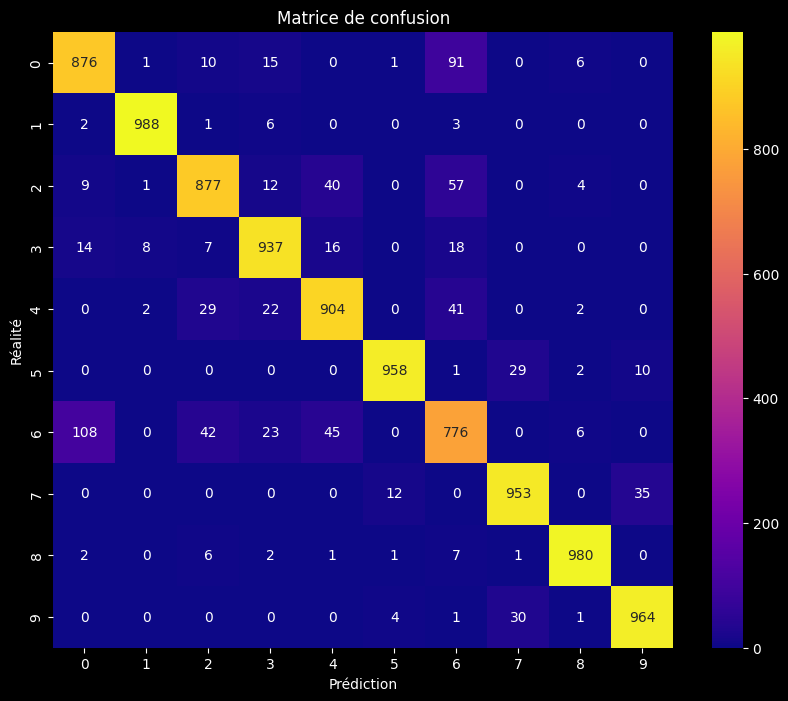

In [42]:
plt.figure(figsize=(10, 8))
sns.heatmap(matrice, annot=True, fmt='d', cmap='plasma',
            xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Prédiction')
plt.ylabel('Réalité')
plt.title('Matrice de confusion')
plt.show()